In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib as mpl
import xarray as xr
import pylab as plt
mpl.rc('figure', figsize=(10,10),facecolor='white', dpi=300)
mpl.rc('figure.subplot', wspace= 0.4, hspace=0.2)
mpl.rc('figure.subplot', hspace= 0.2)
mpl.rc('axes', grid=1, titlesize=14)
mpl.rc('axes.formatter',limits=(-2,5))
mpl.rc('lines', linewidth=2, color='r')
mpl.rc('font', size=16)

In [2]:
def area_grid(lat,lon):
    '''
    Function to calculate surface area per gridbox
    Units: m2
    S = R^2*(lon2-lon1)*(sin lat2 - sin lat1)
    lon in radians, R = 6371 km
    '''
    import numpy as np
    Pi           = np.float128(3.141592653589793238462643383279)
    Earth_Radius = np.float128(6371.0*1.0E3)#equator radius:6378.1*1E3
    lat_bound    = np.float128(89.999999999999999999999999)
    lon          = np.float128(lon)
    lat          = np.float128(lat)
    rlon         = (lon[:]/np.float128(180.0))*Pi
    rlat         = (lat[:]/np.float128(180.0))*Pi
    dlat         = (rlat[1] - rlat[0])/2.0
    dlon         = (rlon[1] - rlon[0])/2.0
    #
    area = np.zeros((len(rlat),len(rlon)),np.float128)
    j=0
    while j < len(rlat):
        if (lat[j] >= lat_bound):
            lat1 = rlat[j]
            lat2 = rlat[j] - dlat/2.0
        elif (lat[j] <= -1.0*lat_bound):
            lat1 = rlat[j] + dlat/2.0
            lat2 = rlat[j]
        else:
            lat1 = rlat[j] + dlat
            lat2 = rlat[j] - dlat
        i=0
        while i < len(rlon):
            lon1 = rlon[i] - dlon
            lon2 = rlon[i] + dlon
            area[j,i] = (Earth_Radius**2)*(abs(np.sin(lat1)-np.sin(lat2))*abs(lon1-lon2))
            i += 1
        j += 1
    return area

In [3]:
#%%
import socket
print(socket.gethostname())
#%%

jupyter-ptg21


In [4]:
ncdata = xr.open_dataset('/gws/nopw/j04/htap2/ptg21/u-cb159/u-cb159_1995-2010_o3_monthly.nc')
lat = ncdata.latitude
lon = ncdata.longitude
#lon = ncdata.variables['longitude'][:]
o3 = ncdata.o3.sel(time=slice('1995-01-01', '2015-01-01'))

In [5]:
ncdata = xr.open_dataset('/gws/nopw/j04/htap2/ptg21/u-cb159/u-cb159_1995-2010_trop_air_mass_monthly.nc')
lat = ncdata.latitude
lon = ncdata.longitude
tropairmass = ncdata.aimass_trop.sel(time=slice('1995-01-01', '2015-01-01'))

In [6]:
#o3 = o3.where(o3*28.8/48<125e-9,o3,0)
o3 = o3*tropairmass
colo3 = o3.sum(dim='model_level_number')

In [7]:
gridcellarea=area_grid(o3.latitude.data, o3.longitude.data)
ozonecolumn = np.empty_like(colo3.data)
for ivar in range (0,len(o3.time)):
    ozonecolumn[ivar,:,:] = colo3.data[ivar,:,:]/gridcellarea

In [8]:
ozonecolumn_in_DU=ozonecolumn/0.048*6.02e23/2.69e20

In [9]:
omi = nc.Dataset('/gws/nopw/j04/ukca_vol2/ptg21/observations/OMI/OMI_trop_O3_2005.nc')
omi_lat = omi['latitude'][:]
omi_lon = omi['longitude'][:]
omi_o3 = omi['O3'][:]
omi_o3 = omi_o3/10.


/tmp/ipykernel_3320/3858766106.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'])


<Figure size 3600x2100 with 0 Axes>

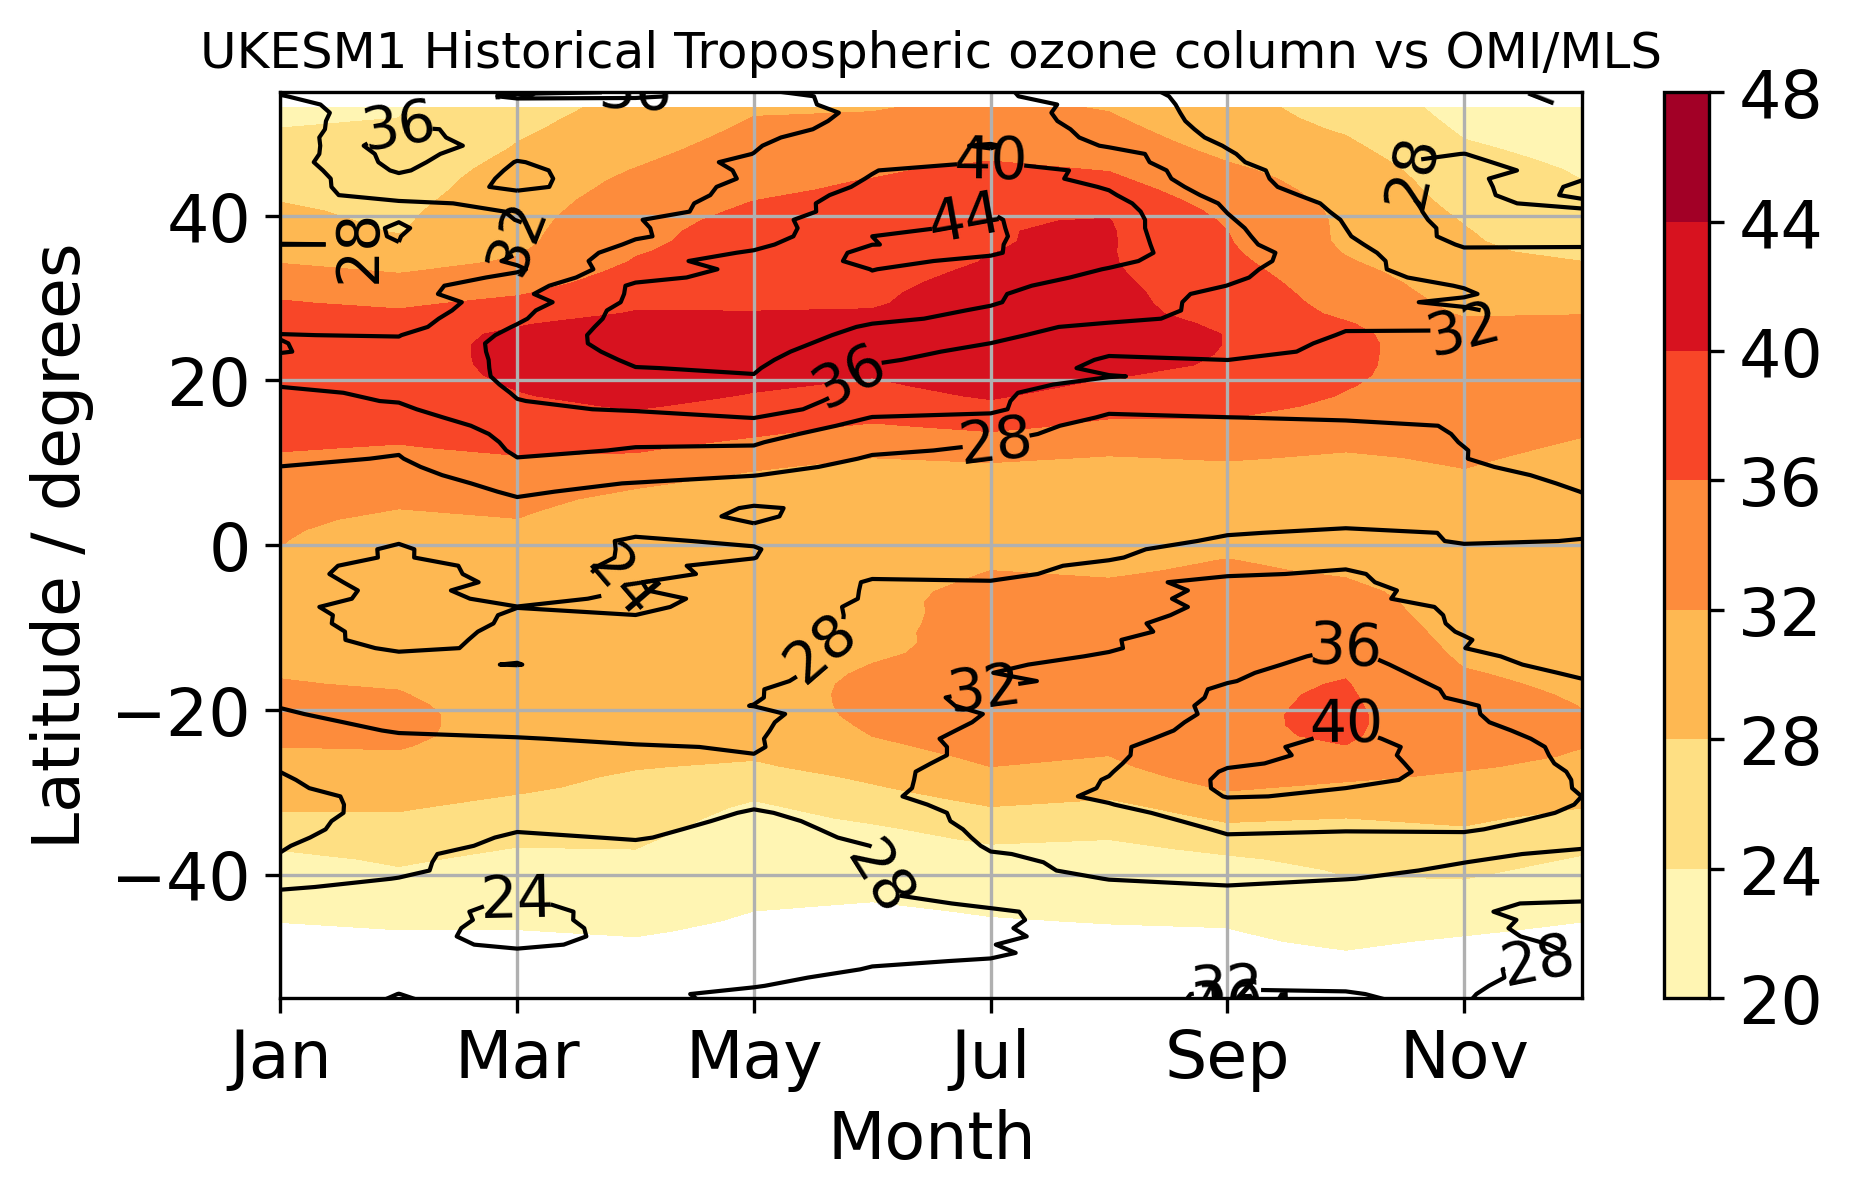

<Figure size 3000x3000 with 0 Axes>

In [10]:
plt.figure(figsize=(12,7), dpi=300)
lonbounds = [ -180, 180]
latbounds = [ -55, 55 ] # degrees east ?

# latitude lower and upper index
latli = np.argmin( np.abs( lat.data - latbounds[0] ) )
latui = np.argmin( np.abs( lat.data - latbounds[1] ) )

fig,ax = plt.subplots(figsize=(7, 4),dpi=300)
cs1= plt.contourf( np.arange(0,12), 
                  lat.data[latli:latui], 
                  np.transpose(np.mean(ozonecolumn_in_DU[-12:,latli:latui,:],axis=2)),
                levels=np.arange(20,52,4), cmap=plt.cm.YlOrRd)
cs2 = plt.contour(np.arange(0,12), 
                  omi_lat, 
                  np.transpose(np.mean(omi_o3.data[-12:,:,:],axis=2)),
                  colors='black',levels=np.arange(20,52,4),linewidths=1)
plt.clabel(cs2, fontsize=14, fmt='%2.0f')
ax.set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'])
ax.set_ylabel('Latitude / degrees')
ax.set_xlabel('Month')
ax.set_ylim((latbounds[0], latbounds[1]))
plt.colorbar(cs1)
plt.title('UKESM1 Historical Tropospheric ozone column vs OMI/MLS', fontsize=12)
plt.show()
plt.savefig('u-bc179_trop_o3_col_vs_OMI_mls.png')

In [11]:
#%%


print('min ', np.min(ozonecolumn_in_DU[:]))


#%%


print('max ', np.max(ozonecolumn_in_DU[:]))


#%%


print('mean ', np.mean(ozonecolumn_in_DU[:]))


# In[ ]:

min  3.1849782
max  71.692215
mean  25.764198
